**Image Classification from scratch**

Introduction

This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or pre-made Keras Application model, We demonstrate the workflow on the kaggle cats vs dogs binary classification datasets.

We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation

**Setup**

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Load the data:the Cats vs Dogs dataset**

Raw data download

First, let's download the 768M ZIP achive of the raw data:

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  18.0M      0  0:00:43  0:00:43 --:--:-- 16.4M 786M   68  540M    0     0  18.1M      0  0:00:43  0:00:29  0:00:14 18.2M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   __notebook_source__.ipynb   'readme[1].txt'
 PetImages		   kagglecatsanddogs_5340.zip


Now we have a PetImages folder which contains two subfolders, cat and Dog. Each subfolder contains image files for each category

In [5]:
!ls PetImages

Cat  Dog


**Filter out corrupted images**

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header

In [6]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
  folder_path = os.path.join("PetImages", folder_name)
  for fname in os.listdir(folder_path):
    fpath=os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()
    
    if not is_jfif:
      num_skipped+=1
      # Delete corrupted image
      os.remove(fpath)

print("Deleted %d images"% num_skipped)

Deleted 1590 images


# **Generate a Dataset**

In [7]:
image_size=(180, 180)
batch_size=128

train_ds = tf.keras.preprocessing.image_dataset_from_directory("PetImages", validation_split=0.2, subset="training", seed=1337, image_size=image_size, batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory("PetImages", validation_split=0.2, subset="validation", seed=1337, image_size=image_size, batch_size=batch_size)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.


2022-11-19 15:36:07.420633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 15:36:07.585818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 15:36:07.586682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 15:36:07.589107: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


**Visualize the data**

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and lael 0 is "cat".

2022-11-19 15:36:12.508096: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


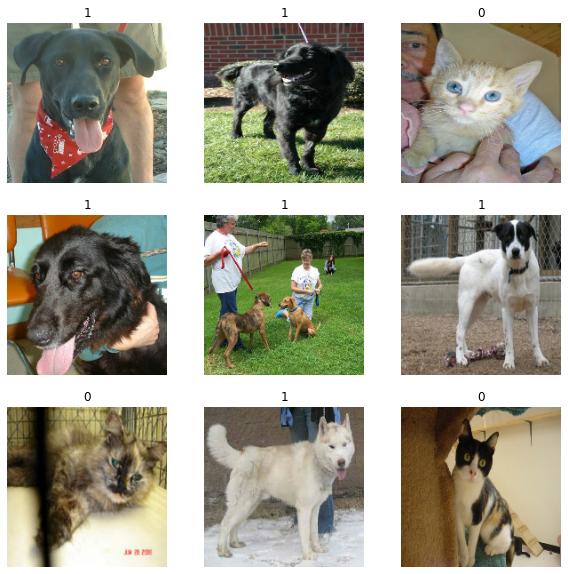

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

**Using image data augmenatation**

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

Let's visualize what the augmented samples look like, by applying data_augmentation repreatedly to the first image in the dataset:

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


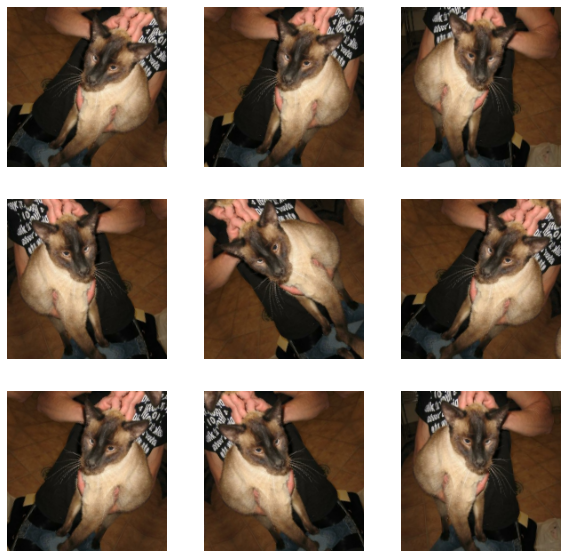

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Standardizing the data**

Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

**Configure the dataset for performance**

Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [11]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

**Build a model**

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best modal configuration, consider using KerasTuner.

Note that:

-->We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.

-->We include a Dropout layer before the final classification layer

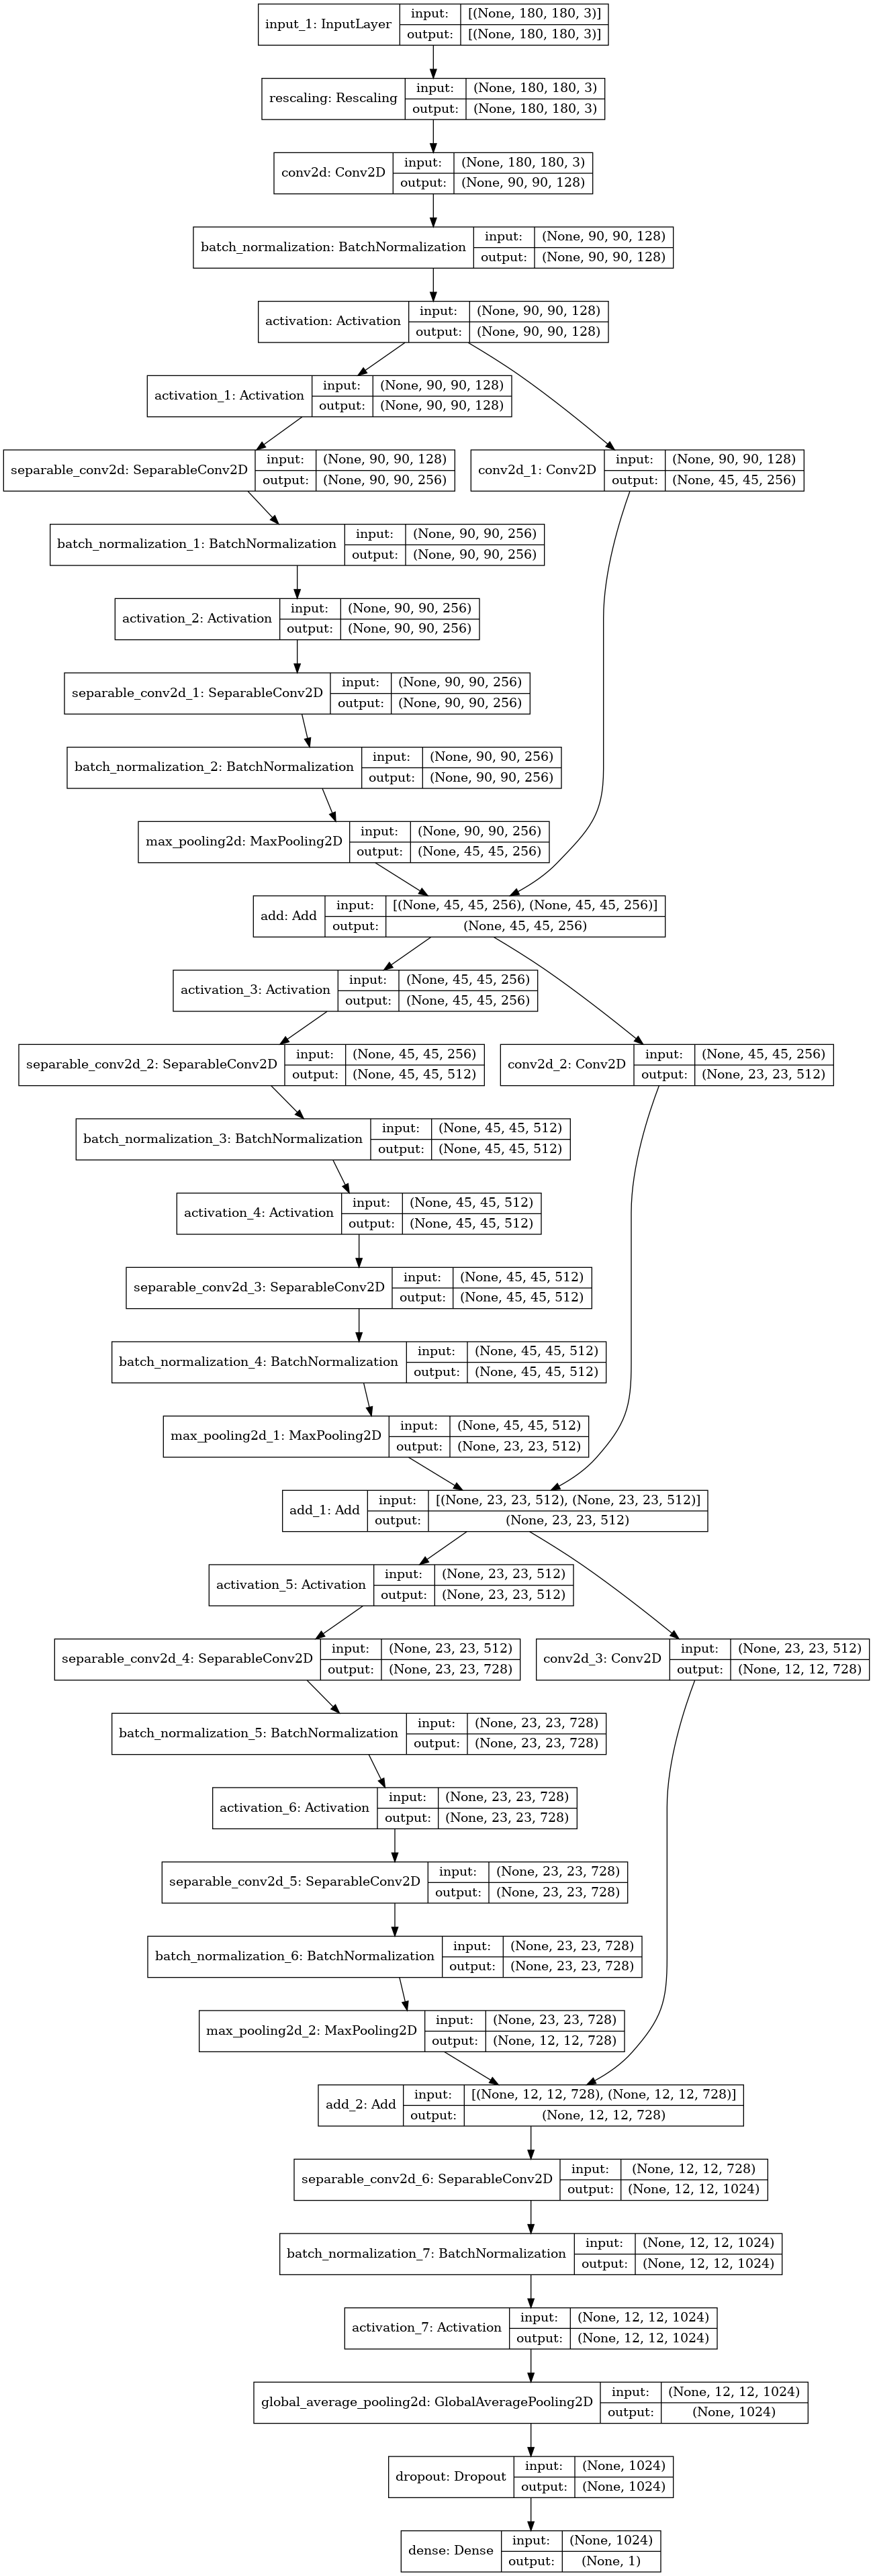

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

**Train the model**

In [13]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2022-11-19 15:36:24.176123: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-11-19 15:36:30.430987: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-19 15:36:31.266322: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-19 15:36:31.298581: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but m

 70/147 [=============>................] - ETA: 1:20 - loss: 0.7019 - accuracy: 0.5942

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 78/147 [==============>...............] - ETA: 1:11 - loss: 0.6969 - accuracy: 0.5984

 97/147 [==================>...........] - ETA: 51s - loss: 0.6825 - accuracy: 0.6107

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


100/147 [===================>..........] - ETA: 48s - loss: 0.6825 - accuracy: 0.6121

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 45s - loss: 0.6810 - accuracy: 0.6130

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


104/147 [====================>.........] - ETA: 44s - loss: 0.6807 - accuracy: 0.6135

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.6388

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 176s 1s/step - loss: 0.6533 - accuracy: 0.6388 - val_loss: 0.7346 - val_accuracy: 0.4957


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/147 [=============>................] - ETA: 1:18 - loss: 0.5380 - accuracy: 0.7320

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 79/147 [===============>..............] - ETA: 1:10 - loss: 0.5301 - accuracy: 0.7361

 98/147 [===================>..........] - ETA: 50s - loss: 0.5188 - accuracy: 0.7448

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


101/147 [===================>..........] - ETA: 47s - loss: 0.5193 - accuracy: 0.7440

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


104/147 [====================>.........] - ETA: 44s - loss: 0.5169 - accuracy: 0.7461

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


105/147 [====================>.........] - ETA: 43s - loss: 0.5165 - accuracy: 0.7463

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.4957 - accuracy: 0.7611

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 164s 1s/step - loss: 0.4957 - accuracy: 0.7611 - val_loss: 0.9540 - val_accuracy: 0.4957
Epoch 3/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/147 [=============>................] - ETA: 1:19 - loss: 0.4219 - accuracy: 0.8131

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 78/147 [==============>...............] - ETA: 1:11 - loss: 0.4216 - accuracy: 0.8120

 97/147 [==================>...........] - ETA: 51s - loss: 0.4127 - accuracy: 0.8168

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


100/147 [===================>..........] - ETA: 48s - loss: 0.4122 - accuracy: 0.8175

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 45s - loss: 0.4110 - accuracy: 0.8183

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


104/147 [====================>.........] - ETA: 44s - loss: 0.4100 - accuracy: 0.8188

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.8267

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 163s 1s/step - loss: 0.3957 - accuracy: 0.8267 - val_loss: 1.1300 - val_accuracy: 0.4957
Epoch 4/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 [=============>................] - ETA: 1:21 - loss: 0.3417 - accuracy: 0.8548

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:12 - loss: 0.3391 - accuracy: 0.8557

 96/147 [==================>...........] - ETA: 53s - loss: 0.3384 - accuracy: 0.8561

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 [===================>..........] - ETA: 49s - loss: 0.3372 - accuracy: 0.8561

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 46s - loss: 0.3358 - accuracy: 0.8560

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 45s - loss: 0.3361 - accuracy: 0.8561

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.8606

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 163s 1s/step - loss: 0.3278 - accuracy: 0.8606 - val_loss: 0.5432 - val_accuracy: 0.7240
Epoch 5/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 65/147 [============>.................] - ETA: 1:24 - loss: 0.2796 - accuracy: 0.8847

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 73/147 [=============>................] - ETA: 1:16 - loss: 0.2800 - accuracy: 0.8842

 92/147 [=================>............] - ETA: 56s - loss: 0.2775 - accuracy: 0.8849

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 95/147 [==================>...........] - ETA: 53s - loss: 0.2784 - accuracy: 0.8845

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 98/147 [===================>..........] - ETA: 50s - loss: 0.2777 - accuracy: 0.8847

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 99/147 [===================>..........] - ETA: 49s - loss: 0.2780 - accuracy: 0.8844

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.8883

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 163s 1s/step - loss: 0.2673 - accuracy: 0.8883 - val_loss: 0.4281 - val_accuracy: 0.7858
Epoch 6/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 [=============>................] - ETA: 1:21 - loss: 0.2507 - accuracy: 0.8962

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:13 - loss: 0.2438 - accuracy: 0.8999

 96/147 [==================>...........] - ETA: 53s - loss: 0.2370 - accuracy: 0.9032

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 [===================>..........] - ETA: 50s - loss: 0.2353 - accuracy: 0.9040

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 46s - loss: 0.2352 - accuracy: 0.9036

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 45s - loss: 0.2351 - accuracy: 0.9036

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.9061

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 164s 1s/step - loss: 0.2280 - accuracy: 0.9061 - val_loss: 0.3580 - val_accuracy: 0.8755
Epoch 7/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 [=============>................] - ETA: 1:20 - loss: 0.2024 - accuracy: 0.9160

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:12 - loss: 0.1995 - accuracy: 0.9177

 96/147 [==================>...........] - ETA: 52s - loss: 0.2033 - accuracy: 0.9159

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 [===================>..........] - ETA: 49s - loss: 0.2024 - accuracy: 0.9163

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 46s - loss: 0.2029 - accuracy: 0.9161

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 45s - loss: 0.2026 - accuracy: 0.9160

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9168

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 163s 1s/step - loss: 0.2010 - accuracy: 0.9168 - val_loss: 0.2617 - val_accuracy: 0.8853
Epoch 8/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/147 [=============>................] - ETA: 1:19 - loss: 0.1850 - accuracy: 0.9211

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 78/147 [==============>...............] - ETA: 1:11 - loss: 0.1861 - accuracy: 0.9208

 98/147 [===================>..........] - ETA: 50s - loss: 0.1882 - accuracy: 0.9202

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


100/147 [===================>..........] - ETA: 48s - loss: 0.1885 - accuracy: 0.9201

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 45s - loss: 0.1877 - accuracy: 0.9202

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


104/147 [====================>.........] - ETA: 44s - loss: 0.1878 - accuracy: 0.9201

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1842 - accuracy: 0.9228

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 163s 1s/step - loss: 0.1842 - accuracy: 0.9228 - val_loss: 0.2291 - val_accuracy: 0.9092
Epoch 9/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 [=============>................] - ETA: 1:20 - loss: 0.1710 - accuracy: 0.9314

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:12 - loss: 0.1720 - accuracy: 0.9310

 96/147 [==================>...........] - ETA: 53s - loss: 0.1764 - accuracy: 0.9277

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 [===================>..........] - ETA: 49s - loss: 0.1757 - accuracy: 0.9278

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 46s - loss: 0.1769 - accuracy: 0.9273

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 45s - loss: 0.1771 - accuracy: 0.9271

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9295

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 163s 1s/step - loss: 0.1726 - accuracy: 0.9295 - val_loss: 0.2189 - val_accuracy: 0.9180
Epoch 10/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/147 [=============>................] - ETA: 1:19 - loss: 0.1560 - accuracy: 0.9393

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 78/147 [==============>...............] - ETA: 1:11 - loss: 0.1560 - accuracy: 0.9396

 97/147 [==================>...........] - ETA: 51s - loss: 0.1556 - accuracy: 0.9389

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


100/147 [===================>..........] - ETA: 48s - loss: 0.1551 - accuracy: 0.9391

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 45s - loss: 0.1550 - accuracy: 0.9394

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


104/147 [====================>.........] - ETA: 44s - loss: 0.1551 - accuracy: 0.9393

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.9398

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 163s 1s/step - loss: 0.1522 - accuracy: 0.9398 - val_loss: 0.1695 - val_accuracy: 0.9340
Epoch 11/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/147 [=============>................] - ETA: 1:19 - loss: 0.1411 - accuracy: 0.9432

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 78/147 [==============>...............] - ETA: 1:11 - loss: 0.1384 - accuracy: 0.9447

 97/147 [==================>...........] - ETA: 51s - loss: 0.1385 - accuracy: 0.9449

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


100/147 [===================>..........] - ETA: 48s - loss: 0.1382 - accuracy: 0.9448

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 45s - loss: 0.1401 - accuracy: 0.9443

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


104/147 [====================>.........] - ETA: 44s - loss: 0.1395 - accuracy: 0.9445

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.9447

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 163s 1s/step - loss: 0.1396 - accuracy: 0.9447 - val_loss: 0.2554 - val_accuracy: 0.9088
Epoch 12/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/147 [=============>................] - ETA: 1:21 - loss: 0.1346 - accuracy: 0.9463

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 77/147 [==============>...............] - ETA: 1:12 - loss: 0.1351 - accuracy: 0.9455

 97/147 [==================>...........] - ETA: 51s - loss: 0.1355 - accuracy: 0.9442

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/147 [===================>..........] - ETA: 49s - loss: 0.1350 - accuracy: 0.9444

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/147 [===================>..........] - ETA: 46s - loss: 0.1356 - accuracy: 0.9443

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 45s - loss: 0.1362 - accuracy: 0.9439

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9440

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 163s 1s/step - loss: 0.1385 - accuracy: 0.9440 - val_loss: 0.2441 - val_accuracy: 0.8975
Epoch 13/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/147 [=============>................] - ETA: 1:20 - loss: 0.1315 - accuracy: 0.9475

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 78/147 [==============>...............] - ETA: 1:11 - loss: 0.1310 - accuracy: 0.9478

 97/147 [==================>...........] - ETA: 52s - loss: 0.1300 - accuracy: 0.9487

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


100/147 [===================>..........] - ETA: 48s - loss: 0.1299 - accuracy: 0.9488

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


103/147 [====================>.........] - ETA: 45s - loss: 0.1294 - accuracy: 0.9492

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


104/147 [====================>.........] - ETA: 44s - loss: 0.1288 - accuracy: 0.9494

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9504

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 164s 1s/step - loss: 0.1260 - accuracy: 0.9504 - val_loss: 0.1969 - val_accuracy: 0.9261
Epoch 14/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/147 [=============>................] - ETA: 1:18 - loss: 0.1288 - accuracy: 0.9457

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 79/147 [===============>..............] - ETA: 1:10 - loss: 0.1274 - accuracy: 0.9468

 98/147 [===================>..........] - ETA: 50s - loss: 0.1283 - accuracy: 0.9479

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


101/147 [===================>..........] - ETA: 47s - loss: 0.1290 - accuracy: 0.9471

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


104/147 [====================>.........] - ETA: 44s - loss: 0.1285 - accuracy: 0.9474

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


105/147 [====================>.........] - ETA: 43s - loss: 0.1277 - accuracy: 0.9478

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


147/147 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9484

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 163s 1s/step - loss: 0.1271 - accuracy: 0.9484 - val_loss: 0.2032 - val_accuracy: 0.9214
Epoch 15/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


KeyboardInterrupt: 

**Run inference on new data**

In [2]:
from IPython.display import Image, display

# Sample images
s1="PetImages/Dog/1947.jpg"
s2="PetImages/Cat/1927.jpg"
s3="PetImages/Dog/1500.jpg"
s4="PetImages/Dog/1147.jpg"

img = keras.preprocessing.image.load_img(
    s1, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])

display(Image(s1))
print(predictions)

NameError: name 'keras' is not defined